In [1]:
import pandas as pa
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import *
from sklearn.ensemble import RandomForestClassifier

#### First lets read the data

In [2]:
titanic_df=pa.read_csv("train.csv")
test_df=pa.read_csv("test.csv")

In [3]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Cleaning the data
#### First thing i want to do is to clean the data a little bit filling the missing values and prepare the data 
#### here i noticed that the Name value have the name and the title so lets split it

In [4]:
import re
def extract_title(dataset):
    title=[]
    Name=[]
    for data in dataset:
        title.append(re.split('(\w+)\.',data)[1])
    return title

In [5]:
titanic_df['Title']=extract_title(titanic_df['Name'])
test_df['Title']=extract_title(test_df['Name'])

#### After the spliting lets see what titles we have here

In [6]:
titanic_df.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

#### lets also count people with each title

In [7]:
titanic_df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Title, dtype: int64

#### Now after this values we see that there is a rare titles i'm not intersted in it so let's stick with 
#### {Mr,Mrs,Miss,Master} and any thing else will be under 'Rare' label

In [8]:
def replace_titles(dataset):
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})

In [9]:
replace_titles(titanic_df)
replace_titles(test_df)

#### Now lets check the uniqe Titles again

In [10]:
titanic_df.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [11]:
titanic_df['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

#### After finishing with Name variable i noticed something in Cabin varible there is multiple cabin number in the same row also 
#### i'm not intersted in the num it self i just want the character {A,B,C,...} so i'm going to extract them

In [12]:
titanic_df['Cabin']=titanic_df.Cabin.str.extract('([A-Za-z])')    
test_df['Cabin']=test_df.Cabin.str.extract('([A-Za-z])')    

C:\Users\ahmed\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
C:\Users\ahmed\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [13]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [14]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


# Filling the missing values
#### to do this first i need to concat the two sets {train,test} to collect all the information in both of them

In [15]:
frames=[titanic_df,test_df]
all_data=pa.concat(frames)

In [16]:
all_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


#### Here i wanted to plot the probability of each title to survive 

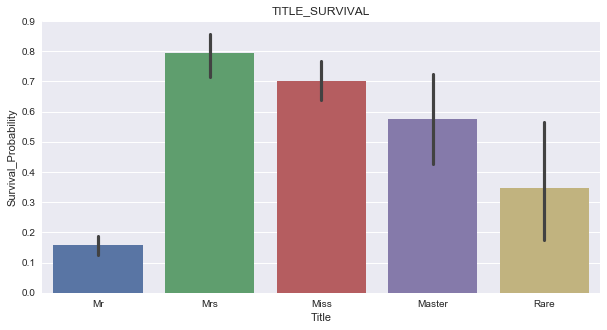

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
Title_survival=sns.barplot(x='Title',y='Survived',data=all_data).set(ylabel='Survival_Probability',title='TITLE_SURVIVAL')

#### Now lets first check the missing values in the data i want to know which columns have the missnings and their count

In [18]:
def values_null(dataset):
    columns={}
    for item in dataset.columns.values:
        if dataset[item].isnull().values.any():
            columns[item]=dataset[item].isnull().sum()
    return columns

In [19]:
values_null(all_data)

{'Age': 263, 'Cabin': 1014, 'Embarked': 2, 'Fare': 1, 'Survived': 418}

#### so first i will start with the easy ones first the fare value i will fill it with the median of the fare values 

In [20]:
test_df['Fare'].isnull().values.any()

True

In [21]:
test_df['Fare']=test_df['Fare'].fillna(all_data.Fare.median())

#### Secound the Embarked values i checked the data and found that the S embark is the biggest one so i will fill the missing values 
#### with it

In [22]:
test_df['Embarked'].isnull().values.any()

False

In [23]:
titanic_df['Embarked'].isnull().values.any()

True

In [24]:
all_data['Fare']=all_data['Fare'].fillna(all_data.Fare.median())
all_data['Embarked']=all_data['Embarked'].fillna('S')

In [25]:
all_data['Embarked'].value_counts()

S    916
C    270
Q    123
Name: Embarked, dtype: int64

In [26]:
titanic_df['Embarked']=titanic_df['Embarked'].fillna('S')

#### Now lets go throught the cabin Variable first i want to see the relation between the Cabin and the Pclass and the Fare 

In [27]:
groups_fare=all_data.groupby(['Cabin','Pclass'])['Fare']

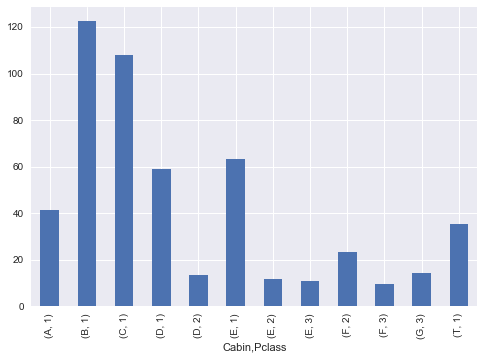

In [28]:
groups_fare.mean().plot(kind='bar')

#### I see from this graph the mean of each cabin with each class i will use this information to predict the cabin value for missing
#### values

#### I Also want to see the count of each cabin in each class to determine which cabin may have the most probability for the passenger 

In [29]:
groups_Pclass=all_data.groupby('Cabin')['Pclass']

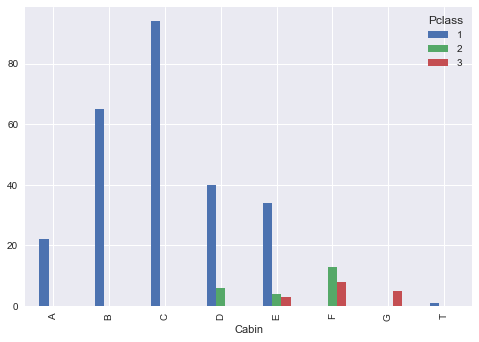

In [30]:
pa.crosstab(all_data['Cabin'],all_data['Pclass']).plot(kind='bar')

In [31]:
pa.crosstab(all_data['Cabin'],all_data['Pclass'])

Pclass,1,2,3
Cabin,,,
A,22,0,0
B,65,0,0
C,94,0,0
D,40,6,0
E,34,4,3
F,0,13,8
G,0,0,5
T,1,0,0


#### After gathring this information i will fill the cabin value manually i also could make an predictive model but i see manual method will be better

In [32]:
def filling_cabin(dataset):
    cabin=[]
    for index,data in dataset.iterrows():
        if data['Pclass']==1:
            if data['Fare']<40:
                cabin.append('A')
            elif data['Fare'] in range(40,60):
                cabin.append('D')
            elif data['Fare'] in range(60,90):
                cabin.append('C')
            else:
                cabin.append('B')
        elif data['Pclass']==2:
                if data['Fare']<10:
                    cabin.append('E')
                elif data['Fare'] in range(10,20):
                    cabin.append('D')
                else:
                    cabin.append('F')
        elif data['Pclass']==3:
                if data['Fare']<15:
                    cabin.append('F')
                elif data['Fare'] in range(15,25):
                    cabin.append('E')
                else:
                    cabin.append('G')
    return cabin
    

In [33]:
non_cabin=all_data[all_data['Cabin'].isnull()]

In [34]:
all_data.loc[all_data['Cabin'].isnull(),'Cabin']=filling_cabin(non_cabin)

#### Now i will plot the same graph again to see what changed ofcourse my method might have some errors but i'm not going to use this information in the model so no problem i think 

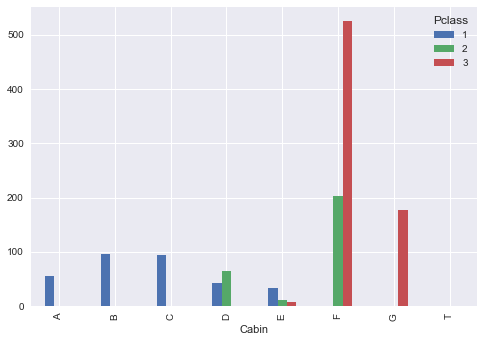

In [37]:
pa.crosstab(all_data['Cabin'],all_data['Pclass']).plot(kind='bar')

In [38]:
non_cabin_train=titanic_df[titanic_df['Cabin'].isnull()]
non_cabin_test=test_df[test_df['Cabin'].isnull()]
titanic_df.loc[titanic_df['Cabin'].isnull(),'Cabin']=filling_cabin(non_cabin_train)
test_df.loc[test_df['Cabin'].isnull(),'Cabin']=filling_cabin(non_cabin_test)

#### Now the Age Value here i'm going to use linear regression model to predict it but first i want to know what features i will need to use in the model 

#### let's examine the Age with Sex 

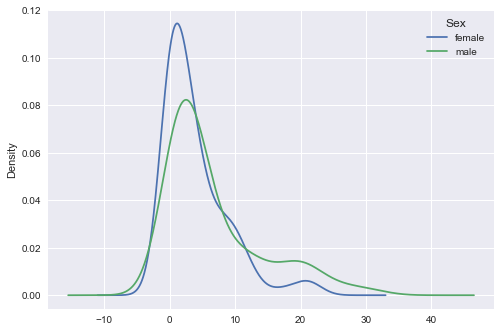

In [39]:
pa.crosstab(all_data['Age'],all_data["Sex"]).plot(kind='kde')

#### Also with the Pclass

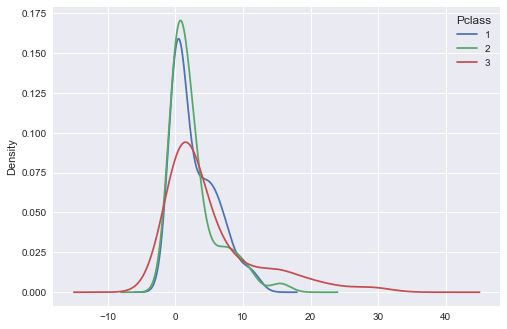

In [40]:
pa.crosstab(all_data['Age'],all_data["Pclass"]).plot(kind='kde')

#### Ok after looking to this graphs i decided that the factors that might affect the Age values is the 
#### Title,Parch,Sex,SibSp,Pclass 

#### I will map this values to numeric values 

In [41]:
mapp_T={'Mr':0,'Mrs':1,'Miss':2,'Master':3,'Rare':4}
mapp_S={'male':0,'female':1}
mapp_E={'C':0,'Q':1,'S':2}
all_data=all_data.replace({"Title":mapp_T,'Sex':mapp_S,'Embarked':mapp_E})
titanic_df=titanic_df.replace({"Title":mapp_T,'Sex':mapp_S,'Embarked':mapp_E})
test_df=test_df.replace({"Title":mapp_T,'Sex':mapp_S,'Embarked':mapp_E})

#### I will test the model first on the present data to see it's accuracy 

In [42]:
copy_data=all_data
copy_data_ged=copy_data[~copy_data['Age'].isnull()]
copy_data_ged=copy_data_ged[copy_data_ged['Title']!=4]
copy_data_ged.loc[copy_data_ged['Age']<1,'Age']=1
x=copy_data_ged[['Sex','Parch','SibSp','Title','Pclass']]
y=copy_data_ged['Age']

In [43]:
ls=Lasso(alpha=0.1)

In [44]:
ls.fit(x,y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [45]:
aged3=ls.predict(x)

#### This is A scatter plot between the real values and the predicted values of the model

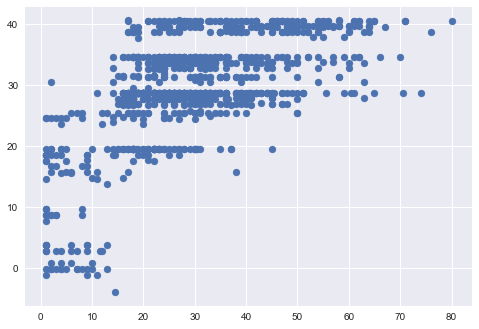

In [46]:
plt.scatter(y,aged3)

In [47]:
np.mean((y-aged3)**2)

125.33288215693533

#### Well this is a high RSS value but i think i can't do better than that 

In [48]:
non_aged=all_data[all_data['Age'].isnull()][['Sex','Parch','SibSp','Title','Pclass']]

In [49]:
non_aged=all_data[all_data['Age'].isnull()][['Sex','Parch','SibSp','Title','Pclass']]

In [50]:
aged=ls.predict(non_aged)

In [51]:
all_data.loc[all_data['Age'].isnull(),'Age']=aged

#### Again this graph to see what difference the model made

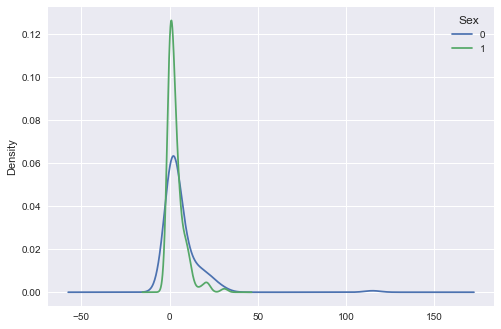

In [52]:
pa.crosstab(all_data['Age'],all_data["Sex"]).plot(kind='kde')

In [53]:
non_aged_train=titanic_df[titanic_df['Age'].isnull()][['Sex','Parch','SibSp','Title','Pclass']]
non_aged_train=titanic_df[titanic_df['Age'].isnull()][['Sex','Parch','SibSp','Title','Pclass']]
aged_train=ls.predict(non_aged_train)
titanic_df.loc[titanic_df['Age'].isnull(),'Age']=aged_train
non_aged_test=test_df[test_df['Age'].isnull()][['Sex','Parch','SibSp','Title','Pclass']]
non_aged_test=test_df[test_df['Age'].isnull()][['Sex','Parch','SibSp','Title','Pclass']]
aged_test=ls.predict(non_aged_test)
test_df.loc[test_df['Age'].isnull(),'Age']=aged_test

#### I think the data now is ready 

# New Values
#### before finishing with the model i think there might be some usefull information behind this values so let's explore it 

#### first the Family size value 

In [54]:
all_data['FSize']=all_data['Parch']+all_data['SibSp']+1
titanic_df['FSize']=titanic_df['Parch']+titanic_df['SibSp']+1
test_df['FSize']=test_df['Parch']+test_df['SibSp']+1

#### This graph shows Survvived people with their family size

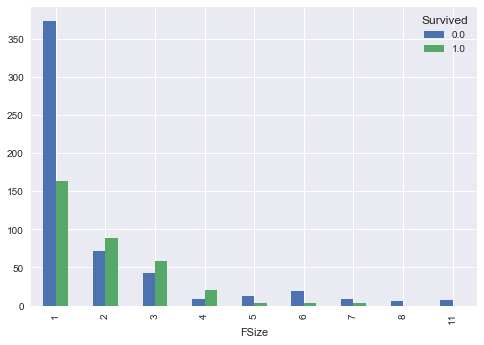

In [55]:
pa.crosstab(all_data['FSize'],all_data['Survived']).plot(kind='bar')

#### I actually got surprised alittle bit i thought single passengers might had better chance to survive more than families,but seems the opposite

#### There is another value i think it will be usefull which is mother and child 

In [56]:
all_data['Mother']=0
all_data['Child']=0
titanic_df['Mother']=0
titanic_df['Child']=0
test_df['Mother']=0
test_df['Child']=0

In [57]:
all_data.loc[(all_data['Age']>18) & (all_data['Sex']==1) & (all_data['Title']!=2) & (all_data['Parch']>0),'Mother']=1
all_data.loc[(all_data['Age']<18),'Child']=1

In [58]:
titanic_df.loc[(titanic_df['Age']>18) & (titanic_df['Sex']==1) & (titanic_df['Title']!=2) & (titanic_df['Parch']>0),'Mother']=1
titanic_df.loc[(titanic_df['Age']<18),'Child']=1
test_df.loc[(test_df['Age']>18) & (test_df['Sex']==1) & (test_df['Title']!=2) & (test_df['Parch']>0),'Mother']=1
test_df.loc[(test_df['Age']<18),'Child']=1

#### now let's see the number of mothers that survived 

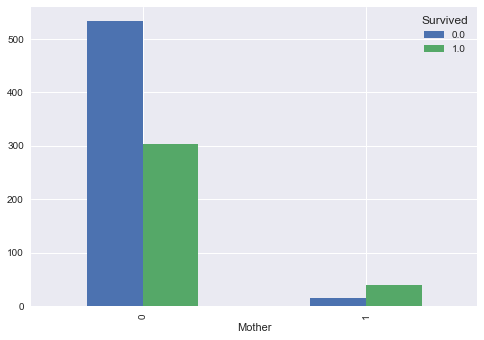

In [59]:
pa.crosstab(all_data['Mother'],all_data['Survived']).plot(kind='bar')

#### let's do the same thing with childs

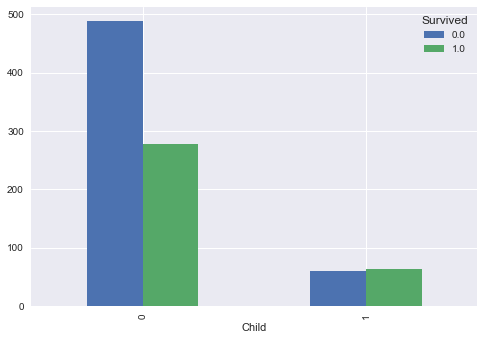

In [60]:
pa.crosstab(all_data['Child'],all_data['Survived']).plot(kind='bar')

#### Another value i want to add is the economy state of passengers well i think rich people may have the chance to survive more than poor people, well let's see

In [61]:
grouped_class=all_data.groupby('Pclass')

#### I will depend on the mean of the fare value for each class to determine the Estate

In [62]:
grouped_class.mean()['Fare']

Pclass
1    87.508992
2    21.179196
3    13.304513
Name: Fare, dtype: float64

In [63]:
all_data['Estate']=0

#### there will be 3 state {3:rich,2:normal,1:poor}

In [64]:
def fillin_Estat(dataset):
    Estate=[]
    for index,data in dataset.iterrows():
        if data['Fare']>=90:
            Estate.append(3)
        elif (data['Fare']>=40) and(data['Fare']<90):
            Estate.append(2)
        else:
            Estate.append(1)
    return Estate

In [65]:
all_data.loc[:,'Estate']=fillin_Estat(all_data)

In [66]:
titanic_df['Estate']=0
titanic_df.loc[:,'Estate']=fillin_Estat(titanic_df)
test_df['Estate']=0
test_df.loc[:,'Estate']=fillin_Estat(test_df)

#### Now let's see the probability of surviving for each Estate

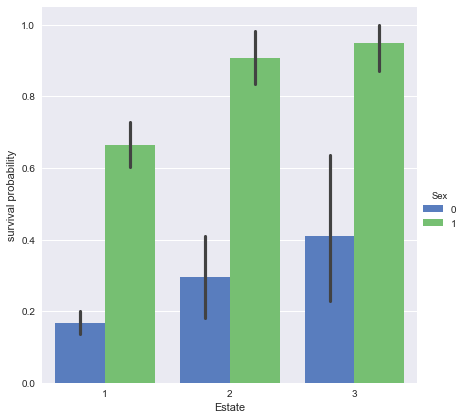

In [67]:
g = sns.factorplot(x="Estate", y="Survived", hue="Sex", data=all_data,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

#### I will also make some more usefull visualizations 
#### this graph shows the probability of survival of  the three emabrks 

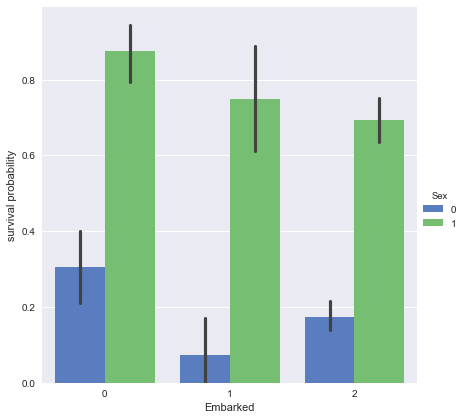

In [68]:
g = sns.factorplot(x="Embarked", y="Survived", hue="Sex", data=all_data,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

#### I also want to see the correlation graph for all the variables to see which one might be usefull in the model

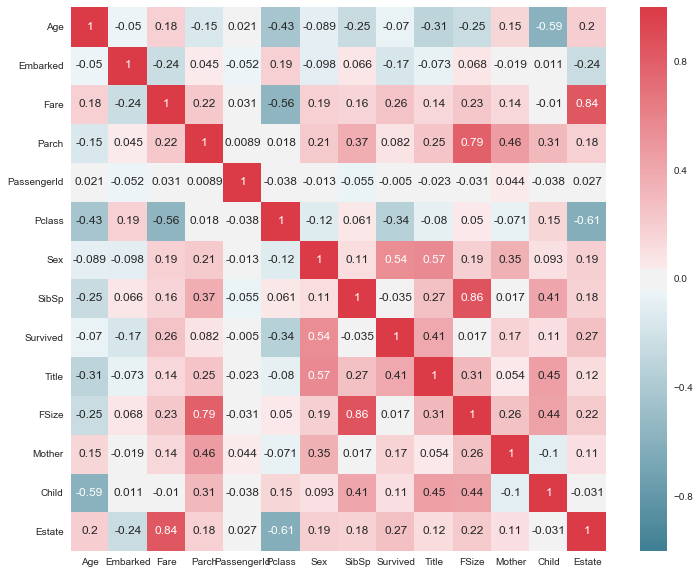

In [71]:
corr = all_data.corr()
_ , ax = plt.subplots( figsize =( 12 , 10 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
    corr, 
    cmap = cmap,
    ax=ax, 
    annot = True, 
)

#### This one shows the boxplot between the Pclass and the Age 

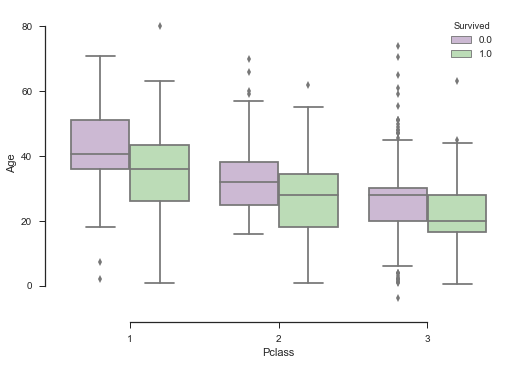

In [72]:
sns.set(style="ticks")
sns.boxplot(x="Pclass", y="Age", hue="Survived", data=all_data, palette="PRGn")
sns.despine(offset=10, trim=True)

#### Here the density of the Age value for each gender

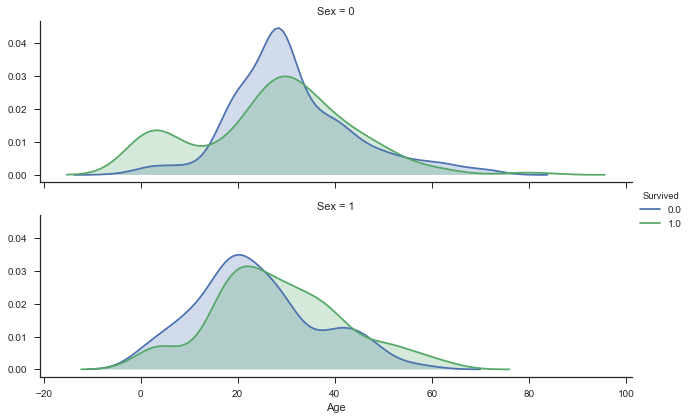

In [73]:
facet = sns.FacetGrid(all_data , hue='Survived' ,aspect=3 , row = 'Sex' )
facet.map(sns.kdeplot , 'Age' , shade= True )
facet.add_legend()

#### I also wanted to see the histogram for the Age for each Embarked

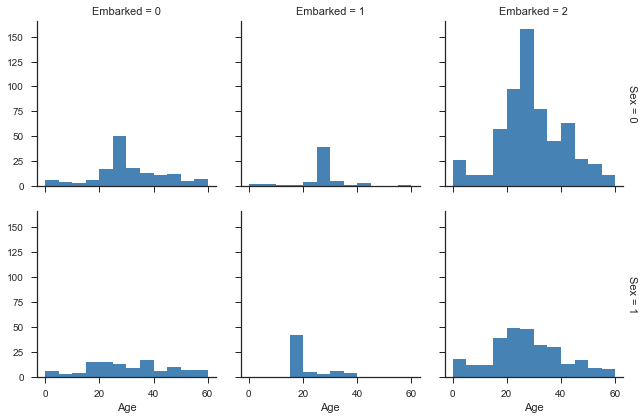

In [74]:
g = sns.FacetGrid(all_data, row="Sex", col="Embarked", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "Age", color="steelblue", bins=bins, lw=0)

#### Finally the survival probability of the family size 

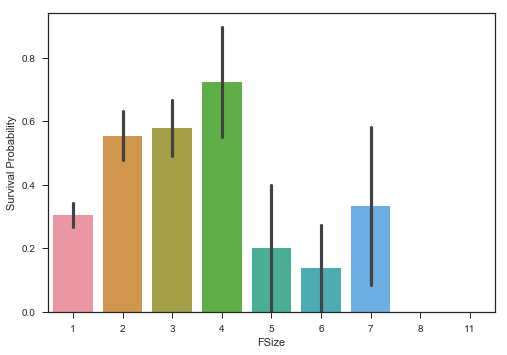

In [75]:
sns.barplot(x='FSize',y='Survived',data=all_data).set(ylabel='Survival Probability')

# The predictive model


In [76]:
features=['Pclass','Sex','Age','SibSp','Parch','Embarked','FSize','Title','Mother','Child','Estate']

In [77]:
forest=RandomForestClassifier()

In [78]:
model=forest.fit(titanic_df[features],titanic_df['Survived'])

In [79]:
importances = model.feature_importances_


In [80]:
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)

In [81]:
indices = np.argsort(importances)[::-1]

In [82]:
for f in range(titanic_df[features].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 2 (0.312293)
2. feature 1 (0.195272)
3. feature 7 (0.148328)
4. feature 0 (0.105998)
5. feature 6 (0.057153)
6. feature 10 (0.046022)
7. feature 3 (0.042235)
8. feature 5 (0.039159)
9. feature 9 (0.027866)
10. feature 4 (0.023283)
11. feature 8 (0.002392)


#### lets see the importance of each feature in our model

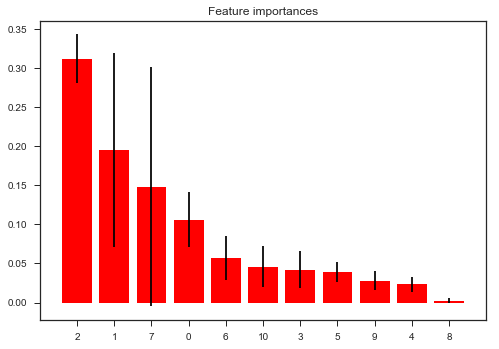

In [83]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(titanic_df[features].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(titanic_df[features].shape[1]), indices)
plt.xlim([-1, titanic_df[features].shape[1]])
plt.show()

In [84]:
y_pred=model.predict(test_df[features])

In [85]:
all_data.loc[all_data['Survived'].isnull(),'Survived']=y_pred

#### Now i finished i hope i did well this was my first self data analysis project ^^